# 作业第四周（2）CNN网络练习

1.仿照课件关于cifar10数据集的分类训练，设计一个CNN网络，训练cifar10的分类操作。
通过优化网络层数与超参数、正则化等措施，将准确率提高到80%。<BR>


In [2]:
#首先执行GPU资源分配代码，勿删除。
import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 导入数据集 cifar10

In [3]:
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import numpy as np
np.random.seed (10)
from matplotlib import pyplot as plt
%matplotlib inline

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()
x_train_raw.shape, y_train_raw.shape, x_test_raw.shape, y_test_raw.shape

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d8441_7c because the default path (/home/student/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
x_train = x_train_raw.astype("float32") / 255
x_test = x_test_raw.astype("float32") / 255
y_train = np_utils.to_categorical(y_train_raw, 10)
y_test = np_utils.to_categorical(y_test_raw, 10)
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### 图像增强

In [5]:
# image augmentation
from keras.preprocessing.image import ImageDataGenerator

generated_images = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

generated_images.fit(x_train)

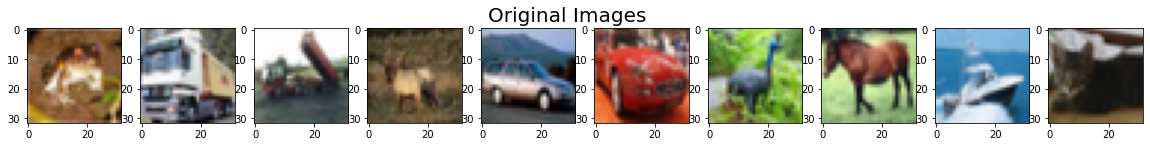

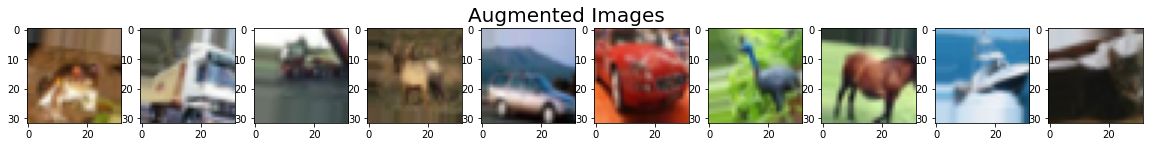

In [6]:
# show images
x_train_subset = np.squeeze(x_train[:10])
 
fig = plt.figure(figsize=(20, 2))
# original images
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Original Images', fontsize=20)
plt.show()
 
# augmented images
fig = plt.figure(figsize=(20, 2))
for x_batch in generated_images.flow(x_train_subset, batch_size=12, shuffle=False):
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)# 总标题
    plt.show()
    break

### 使用VGG作为训练模型

In [7]:
# VGG
lr = 0.1
lr_drop = 20
batch_size = 128
epochs = 250

def lr_scheduler(epoch):
    return lr * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)

def VGG():
    model = Sequential()
    weight_decay = 0.0005

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3),kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

model = VGG()
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [7]:
history = model.fit_generator(generated_images.flow(x_train, y_train, batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks=[reduce_lr],
                                  verbose=1)
model.save_weights('save/3190105708_vgg.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/250
390/390 [==============================] - 31s 79ms/step - loss: 23.2844 - accuracy: 0.1721 - val_loss: 17.9705 - val_accuracy: 0.0565
Epoch 2/250
390/390 [==============================] - 30s 78ms/step - loss: 11.9706 - accuracy: 0.2552 - val_loss: 9.4134 - val_accuracy: 0.0809
Epoch 3/250
390/390 [==============================] - 30s 78ms/step - loss: 6.4375 - accuracy: 0.3211 - val_loss: 5.6006 - val_accuracy: 0.1444
Epoch 4/250
390/390 [==============================] - 30s 78ms/step - loss: 3.8868 - accuracy: 0.3840 - val_loss: 3.7490 - val_accuracy: 0.2279
Epoch 5/250
390/390 [==============================] - 30s 78ms/step - loss: 2.6818 - accuracy: 0.4468 - val_loss: 2.9688 - val_accuracy: 0.3678
Epoch 6/250
390/390 [==============================] - 30s 77ms/step - loss: 2.1166 - accuracy: 0.4978 - val_loss: 2.1531 - val_accuracy: 0.4571
Epoch 7/250
390/390 [==============================

390/390 [==============================] - 30s 77ms/step - loss: 0.5187 - accuracy: 0.9223 - val_loss: 0.5799 - val_accuracy: 0.9083
Epoch 112/250
390/390 [==============================] - 30s 77ms/step - loss: 0.5208 - accuracy: 0.9198 - val_loss: 0.5645 - val_accuracy: 0.9115
Epoch 113/250
390/390 [==============================] - 30s 77ms/step - loss: 0.5172 - accuracy: 0.9214 - val_loss: 0.5413 - val_accuracy: 0.9142
Epoch 114/250
390/390 [==============================] - 30s 78ms/step - loss: 0.5139 - accuracy: 0.9225 - val_loss: 0.5624 - val_accuracy: 0.9110
Epoch 115/250
390/390 [==============================] - 32s 81ms/step - loss: 0.5116 - accuracy: 0.9227 - val_loss: 0.5626 - val_accuracy: 0.9097
Epoch 116/250
390/390 [==============================] - 30s 78ms/step - loss: 0.5109 - accuracy: 0.9219 - val_loss: 0.5433 - val_accuracy: 0.9131
Epoch 117/250
390/390 [==============================] - 32s 81ms/step - loss: 0.5087 - accuracy: 0.9226 - val_loss: 0.5570 - val_ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



390/390 [==============================] - 33s 85ms/step - loss: 0.3710 - accuracy: 0.9509 - val_loss: 0.4778 - val_accuracy: 0.9251
Epoch 152/250
390/390 [==============================] - 32s 83ms/step - loss: 0.3686 - accuracy: 0.9528 - val_loss: 0.4866 - val_accuracy: 0.9240
Epoch 153/250
390/390 [==============================] - 30s 78ms/step - loss: 0.3665 - accuracy: 0.9520 - val_loss: 0.4895 - val_accuracy: 0.9221
Epoch 154/250
390/390 [==============================] - 31s 79ms/step - loss: 0.3645 - accuracy: 0.9525 - val_loss: 0.4939 - val_accuracy: 0.9211
Epoch 155/250
390/390 [==============================] - 33s 83ms/step - loss: 0.3642 - accuracy: 0.9526 - val_loss: 0.4864 - val_accuracy: 0.9243
Epoch 156/250
390/390 [==============================] - 30s 78ms/step - loss: 0.3629 - accuracy: 0.9524 - val_loss: 0.4749 - val_accuracy: 0.9260
Epoch 157/250
390/390 [==============================] - 30s 78ms/step - loss: 0.3595 - accuracy: 0.9521 - val_loss: 0.4955 - val_ac

Epoch 207/250
390/390 [==============================] - 30s 78ms/step - loss: 0.3034 - accuracy: 0.9652 - val_loss: 0.4615 - val_accuracy: 0.9299
Epoch 208/250
390/390 [==============================] - 30s 77ms/step - loss: 0.3047 - accuracy: 0.9646 - val_loss: 0.4653 - val_accuracy: 0.9288
Epoch 209/250
390/390 [==============================] - 31s 78ms/step - loss: 0.3003 - accuracy: 0.9665 - val_loss: 0.4632 - val_accuracy: 0.9298
Epoch 210/250
390/390 [==============================] - 30s 78ms/step - loss: 0.3035 - accuracy: 0.9651 - val_loss: 0.4603 - val_accuracy: 0.9306
Epoch 211/250
390/390 [==============================] - 30s 77ms/step - loss: 0.3016 - accuracy: 0.9660 - val_loss: 0.4613 - val_accuracy: 0.9299
Epoch 212/250
390/390 [==============================] - 30s 78ms/step - loss: 0.3004 - accuracy: 0.9662 - val_loss: 0.4619 - val_accuracy: 0.9286
Epoch 213/250
390/390 [==============================] - 30s 77ms/step - loss: 0.2967 - accuracy: 0.9678 - val_loss: 0

### 测试集准确率为 93.03%

In [12]:
import os
os.path.exists(os.path.join(os.getcwd(), "save/3190105708_vgg.h5"))

True

In [16]:
model.load_weights("./save/3190105708_vgg.h5")
socres = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.4577 - accuracy: 0.9303


### 预测错误的结果用红色标出

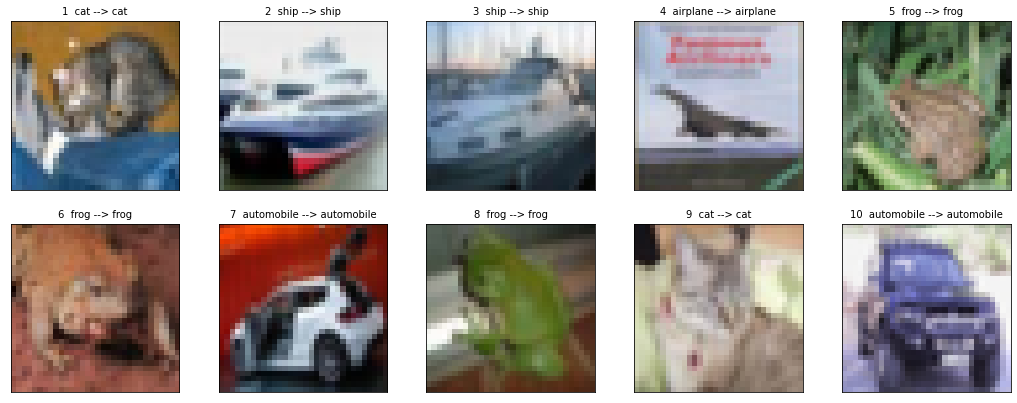

In [20]:
prediction = model.predict_classes(x_test)

label_dict={0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(18,18)
    if num > 25:
        num = 25
    for i in range(0, num):
        ax = plt.subplot(5,5,1+i)
        ax.imshow(images[idx])
        title = str(i+1) + '  ' + label_dict[labels[i][0]]
        if len(prediction) > 0:
            title += ' --> ' + label_dict[prediction[i]]
            if labels[i][0] != prediction[i]:
                color = "red"
            else: 
                color = "black"
            ax.set_title(title, fontsize=10, color=color)
            ax.set_xticks([])
            ax.set_yticks([])
            idx += 1
    plt.show()

plot_images_labels_prediction(x_test_raw, y_test_raw, prediction, idx=0)    

### 查看预测概率

label: cat predict: cat


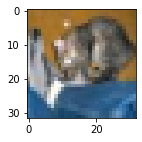

airplaneProbability:0.000015250
automobileProbability:0.000000498
birdProbability:0.000024820
catProbability:0.999812901
deerProbability:0.000011474
dogProbability:0.000043195
frogProbability:0.000075021
horseProbability:0.000002287
shipProbability:0.000011782
truckProbability:0.000002917


In [26]:
Predicted_Probability = model.predict(x_test)

def show_Predicted_Probability(y, prediction, x_img, Predicted_Probability,i):
    print('label:',label_dict[y[i][0]], 'predict:',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_img[i],(32,32,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j] + 'Probability:%1.9f'%(Predicted_Probability[i][j]))
        
show_Predicted_Probability(y_test_raw, prediction, x_test_raw, Predicted_Probability, 0)

### 混淆矩阵

In [29]:
import pandas as pd
print(label_dict)
pd.crosstab(y_test_raw.reshape(-1), prediction, rownames=["label"], colnames=["predict"])

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,935,2,23,7,1,0,2,1,26,3
1,1,981,1,0,0,0,0,1,3,13
2,16,1,928,10,11,7,14,7,3,3
3,11,3,26,832,13,75,25,4,6,5
4,3,0,19,20,923,6,14,14,1,0
5,2,1,16,75,17,860,9,17,2,1
6,6,0,10,9,2,2,970,0,1,0
7,4,1,10,5,7,8,1,964,0,0
8,13,2,2,4,1,0,2,0,970,6
